# Hovmoller plot of NDVI and Rainfall

__What does this notebook do?__ This notebook opens a shape file of transects, allows you to select a transect by number (or plot all sites), and plot a hovmoller diagram of the site NDVI based on datacube landsat surface reflectance data and BoM rainfall data.

__Before you run this notebook:__

__you will need:__

  * a shapefile of the site transects in EPSG 4326 in a known location on raijin
  * to use the rainfall data you will need to request access to project r78 on the NCI
  
__Background:__  
The Normalised Difference Vegetation Index [NDVI](https://ieeexplore.ieee.org/abstract/document/1645279/) is a remote sensing index commonly used to 
examine vegetation distribution and condition. Values are between -1 and 1, with values below 0 indicating the presence of water.

$$\begin{eqnarray}
NDVI &=& \frac {(NIR-RED)}{(NIR+RED)}\ \\
\end{eqnarray}$$

__Date:__ June 2018

__Authors:__ Bex Dunn, Leo Lymburner


### Set up modules, functions and libraries

In [1]:
#in this notebook we want to plot non-interactively
%matplotlib inline

#suppress warnings thrown when rainfall data is imported
# import logging
# logging.getLogger('rasterio._gdal').setLevel(logging.ERROR)
# import warnings

#get standard libraries
import datetime as dt
import fiona
import geopandas as gpd
import shapely.geometry
from shapely.geometry import shape
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import colors
from matplotlib import pyplot as plt
import matplotlib.dates
import numpy as np
import os
import pickle
import rasterio
import rasterio.features
import sys
import xarray as xr

#modules for datacube
import datacube
from datacube.utils import geometry
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/10_Scripts/'))
import DEAPlotting, DEADataHandling
from FileDialogs import *

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

#alias for datacube
dc = datacube.Datacube(app='dc-BoMrainfallandNbart')

### Set up functions for this notebook

In [2]:
#This defines the function that converts a linear vector file into a string of x,y coordinates
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }

def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    gets the transect
    """
    #Changed for py3 compatibility 17.03.17
    dist = [i for i in range(0, int(geom.length), resolution)]
    #points = zip(*[geom.interpolate(d).coords[0] for d in dist]) py2
    points = list(zip(*[geom.interpolate(d).coords[0] for d in dist])) #py3
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)
def load_rainfall(query):
    
    dc_rf =datacube.Datacube(config='/g/data/r78/bom_grids/rainfall.conf')
    
    rf_data = dc_rf.load(product = 'rainfall_grids_1901_2017',**query)

    return rf_data

## add the path to the input shapefile

In [3]:
#transects file will be the file containing our transects
transects_file = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/transects/merged2_hovmoller_transects2.shp'
transects_df = gpd.read_file(transects_file)
transects_df.crs

{'init': 'epsg:4326'}

## Define the epoch

In [16]:
#Define temporal range
start_of_epoch = '1987-10-01' 
end_of_epoch =  '2017-10-01'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 1987-10-01 to 2017-10-01


### Set up query

In [17]:
#use fiona module to open the shape file
transects = fiona.open(transects_file)

#this statement asks you to choose a shapefile. put in a number and press enter.
i = int(input("choose the index of the transect you would like to plot:"))
#for i in range(len(transects)):

geom1 = shape(transects[i]['geometry'])
geom_query1 = geom_query(geom1)
query = {
    'time': (start_of_epoch, end_of_epoch),  
}
query.update(geom_query(geom1, geom_crs=transects.crs_wkt)) 

choose the index of the transect you would like to plot:0


### use the transect dataframe to get transect metadata

In [18]:
#use the transect dataframe to get transect metadata
transect_index = transects_df.index[i]
transect_name = transects_df['Name'][i] 
try:
    print(transect_name)
except TypeError as err:
    print("TypeError: {0}".format(err))
    print(transect_name)

#create a filename for the transect
shape_name = transect_name.split()
shape_name ='_'.join(shape_name)
shape_name=shape_name+'_ix'+str(transect_index)
print(shape_name)

#setup a save directory for our data
savepath ='/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/'+shape_name+'_/'
try:
        os.mkdir(savepath)
except OSError as err:
        print("OS error: {0}".format(err))

BasaltR_AmeliaDowns
BasaltR_AmeliaDowns_ix0
OS error: [Errno 17] File exists: '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/BasaltR_AmeliaDowns_ix0_/'


### Check if this notebook has already been run and the data saved:

In [19]:
print(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl')

/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/BasaltR_AmeliaDowns_ix0_/hov_data_BasaltR_AmeliaDowns_ix0_1987-10-01_2017-10-01.pkl


### If not, pull in rainfall and nbar 

In [20]:
if os.path.isfile(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl'):
    f = open(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl', 'rb')
    hov_data = pickle.load(f) 
    f.close()
    if hov_data is not None: 
        print('loaded data from file')
        ds = hov_data['ds']
        Studysite_rain=hov_data['Studysite_rain']
    
else:
    print('did not load data from previous run')
    #use our DEADataHandling function to load landsat data for all sensors in epoch and mask out cloudy scenes
    ds = DEADataHandling.load_clearlandsat(dc, query,product='nbart',masked_prop=0.80)
    print('loaded SR data from DEA, loading rainfall data')
    #Grab bom_rainfall_grids from the datacube
    Studysite_rain = load_rainfall(query)
    print('loaded bom rainfall grids from DEA')

loaded data from file


### resample gridded rainfall data

In [21]:
#resample xarray Dataset Studysite_rain by Annual'AS' to get yearly avg with year starting in october
#Note that the resampling we did means that each year is labelled according to its first day  
rain_sp = Studysite_rain.mean(dim = ('latitude','longitude'))
month_sp = rain_sp.resample('MS', dim = 'time', how = 'mean')
year_avg = Studysite_rain.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)
# Create a spatial average
year_avg_sp = year_avg.mean(dim = ('latitude', 'longitude'))

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
  after removing the cwd from sys.path.
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
  """


### Set up some colour maps for the Hovmoller plots

In [22]:
#This controls the colour map used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
#Be aware that clip = True might be causing issues
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N, clip=True)

### Set up data for Hovmoller plots and calculate NDVI

#### Build 2D transect dataset for hovmoller plot

In [23]:
## Compress 
ds.crs
crs = ds.crs
crs_wkt = ds.crs.wkt
geom_w = warp_geometry(geom1, query['crs'], crs_wkt)
hov_ds= transect(ds, geom_w, 25)   

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


In [24]:
#calculate NDVI here
hov_multi_ndvi = ((hov_ds.nir-hov_ds.red)/(hov_ds.nir+hov_ds.red))
hov_multi =hov_ds
hov_multi_ndvi_drop = hov_multi_ndvi

### Make Hovmoller plot

transect image: 


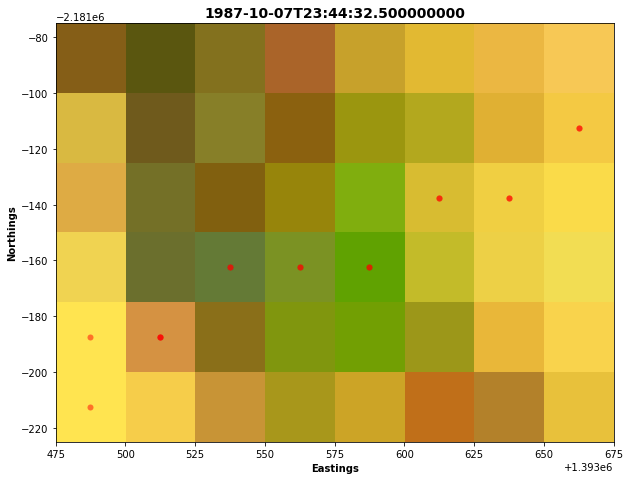

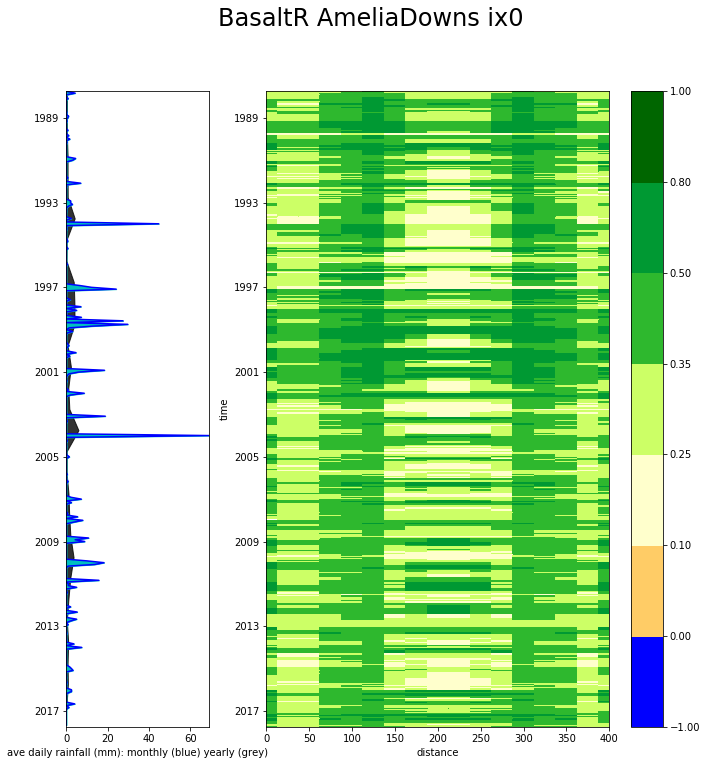

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect image: ')
    DEAPlotting.three_band_image(ds, bands=['swir1','nir','green'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_HovImg_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()

#Make a hovmoller plot and save it to file.
#Use firstyear and last year to zoom into periods of interest
firstyearhov = start_of_epoch#'1987-06-01'
lastyearhov = end_of_epoch #'2016-12-31'
fig = plt.figure(figsize=(11.27,11.69))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
ax1 = plt.subplot(gs[0, 0])
ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

#set up fill time as a datetime 64 object for matplotlib input
#set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))
plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
#set up variables to plot the fill behind the months data
mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

ax2 = plt.subplot(gs[0, 1])
hov_multi_ndvi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm, vmin=-1, vmax =1)
#fig.delaxes(fig.axes[]) #remove current colour bar
plt.axis([0, hov_multi_ndvi_drop.distance.max(), lastyearhov , firstyearhov])
ax2.set_anchor("SE")
#make a title replacing underscores with spaces
plt.suptitle(shape_name.replace('_',' '), fontsize ='24')

#save plot to file
plt.savefig('{}{}_HovPlot_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
plt.show()

### Save the data to an output file for future use

In [26]:
try:
    #make a dictionary of the data we want to save
    hov_data = {'ds':ds, 'Studysite_rain':Studysite_rain,'rain_sp':rain_sp,'month_sp':month_sp,
                'year_avg':year_avg,'year_avg_sp':year_avg_sp,'hov_ds':hov_ds, 'start_of_epoch': start_of_epoch, 
                'end_of_epoch':end_of_epoch,'ndvi_cmap':ndvi_cmap, 'ndvi_norm':ndvi_norm, 'ndvi_bounds':ndvi_bounds}

    f = open(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl', 'wb')
    pickle.dump(hov_data,f) 
    print('saved data to file')
    #pickle.dump(pickle_vars,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
    f.close()
except:
    print('did not save to file')

saved data to file
